# Goal: to predict the sales price for each house. For each Id in the test set, predict the value of the SalePrice

# 1.1 import necessary libraries

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import norm

# ML models
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score


# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# metrics to evaluate regression model
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## 1.2 Load datasets

In [35]:
train_df=pd.read_csv('train.csv') # contains features and target variable (SalePrice)
test_df =pd.read_csv('test.csv') # only features; 
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [36]:
test_df.head() # test_df had same features as train_df except SalePrice (target var)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# 2. Data Wangling/Processing

## 2.1 Merging training and testing dataframes

In [37]:
## separate target column with unique Id from train_df
target=train_df[['Id','SalePrice']]
target.describe()

,Id,SalePrice
count,1460.000000,1460.000000
mean,730.500000,180921.195890
std,421.610009,79442.502883
min,1.000000,34900.000000
25%,365.750000,129975.000000
50%,730.500000,163000.000000
75%,1095.250000,214000.000000
max,1460.000000,755000.000000


In [38]:
target.isnull().sum() # Glad to see target feature had no missing values

Id           0
SalePrice    0
dtype: int64

In [39]:
train_data=train_df.drop(columns='SalePrice', axis=1) # dropping target column from train_df
train_data.shape

(1460, 80)

### It's great to see no nan's in SalePrice column, minimum value is ~35k; so i can happily slice SalePrice column from train_df; do wrangling and EDA of train and test df's.

In [40]:
test_df.shape

(1459, 80)

### Important to note here the 'Id' column values in train_df and test_df are consecutive, so i can do pre-processing of both training and testing dataframes together by concatenating both datasets row-wise, and slice them before building ML models.

In [41]:
df=pd.concat([train_data,test_df],axis=0)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [42]:
df['TotalBsmtSF'].replace(0, 1, inplace=True) # Basement range 0-6110 sft; 0 means there is no basement in the house. Rather than removing the rows with 0 basement and/or imputing the 0's with column menas; I am replacing 0 with 1 (just adding 1 sft doesn't inflates the column values)

In [43]:
df['TotalBsmtSF'].describe()

count    2918.000000
mean     1051.804318
std       440.702475
min         1.000000
25%       793.000000
50%       989.500000
75%      1302.000000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

In [44]:
df.shape

(2919, 80)

## 2.2 Missing values

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
LotFrontage      486
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
GarageCars         1
KitchenQual        1
BsmtFinSF1         1
SaleType           1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Exterior2nd        1
Exterior1st        1
GarageArea         1
Electrical         1
KitchenAbvGr       0
dtype: int64


<AxesSubplot:>

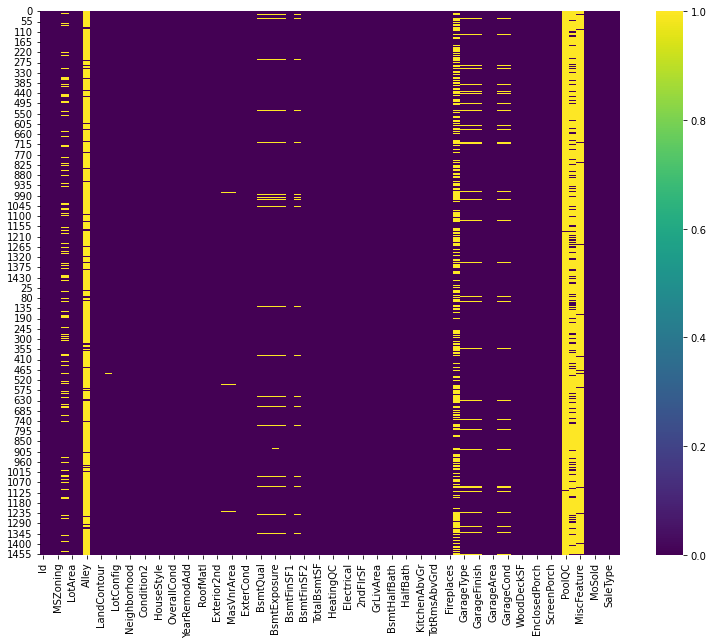

In [45]:
print(df.isnull().sum().sort_values(ascending=False)[:35]) # print sum of missing values

fig, ax = plt.subplots(figsize=(13,10))   
sns.heatmap(df.isnull(), cmap='viridis', ax=ax) # heatmap of missing values

# 2.2 EDA
## 2.2.1 Distribution of SalePrice (target var)

Skewness: 1.882876
Kurtosis: 6.536282


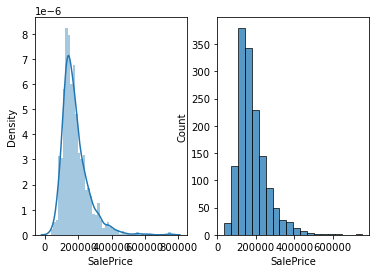

In [46]:
fig, ax =plt.subplots(1,2)
sns.distplot(target['SalePrice'], kde=True, ax=ax[0])
sns.histplot(target['SalePrice'], bins=20, ax=ax[1])

print('Skewness: %f' %target['SalePrice'].skew())
print('Kurtosis: %f' %target['SalePrice'].kurt())

In [47]:
high_price_houses=target.loc[target['SalePrice']>=500000]
medium_price_houses=target.loc[(target['SalePrice']>=100000)& (target['SalePrice']<=200000)]
low_price_houses=target.loc[target['SalePrice']<=100000]

print('Number of houses with >500k price:', high_price_houses.shape[0], 
      '\nNumber of houses with <=100k price:',low_price_houses.shape[0],
      '\nNumber of houses with 100-200k price:',medium_price_houses.shape[0])

Number of houses with >500k price: 9 
Number of houses with <=100k price: 123 
Number of houses with 100-200k price: 919


##### What features make >500k houses pricy?

# 2.3 Numeric Columns

In [48]:
num_cols=df.select_dtypes(exclude='object')
print(num_cols.columns)
print(num_cols.shape)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')
(2919, 37)


In [17]:
num_cols.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,608.0,0,42,0,0,0,0,0,9,2008
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,642.0,0,35,272,0,0,0,0,2,2006
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,836.0,192,84,0,0,0,0,0,12,2008


In [18]:
# are any missing values in numeric columns?
num_cols.isnull().sum().sort_values(ascending=False).head(15)

LotFrontage      486
GarageYrBlt      159
MasVnrArea        23
BsmtHalfBath       2
BsmtFullBath       2
BsmtFinSF2         1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF1         1
KitchenAbvGr       0
3SsnPorch          0
EnclosedPorch      0
OpenPorchSF        0
dtype: int64

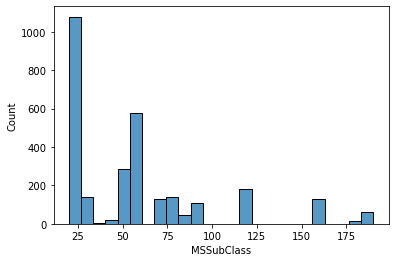

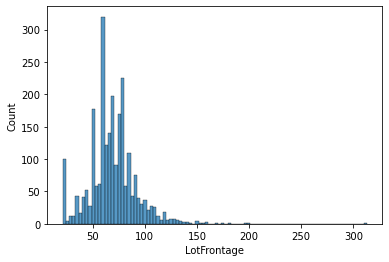

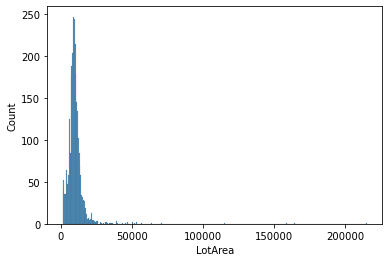

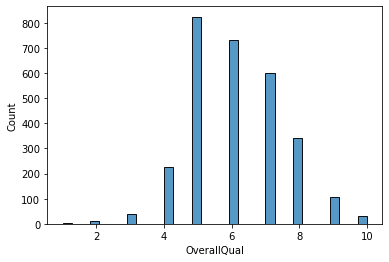

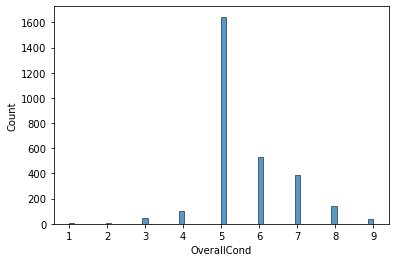

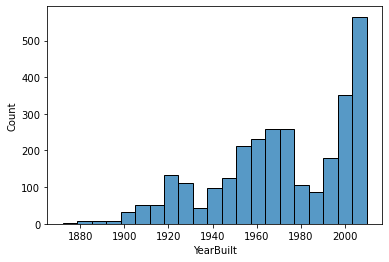

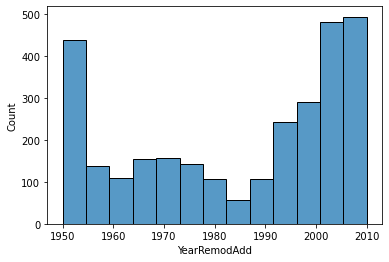

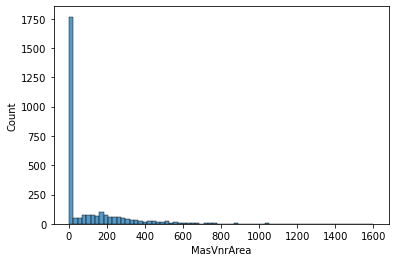

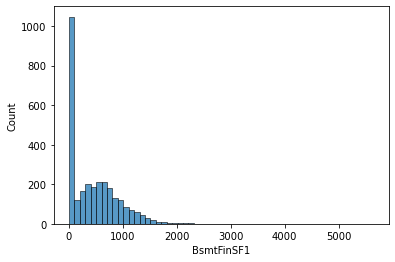

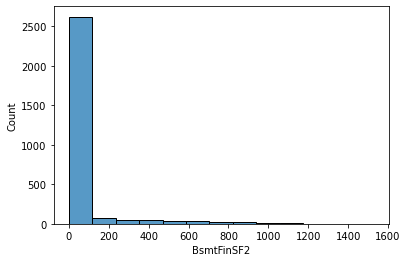

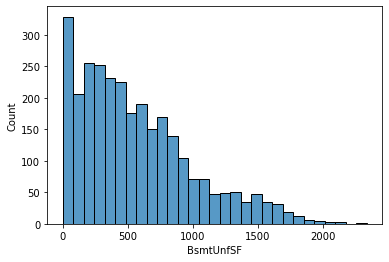

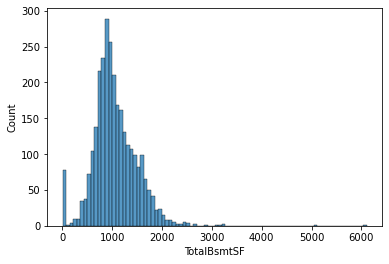

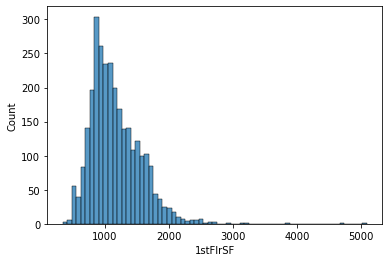

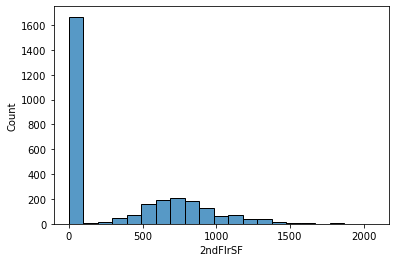

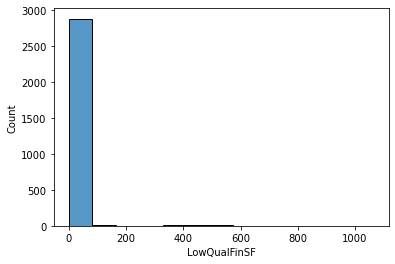

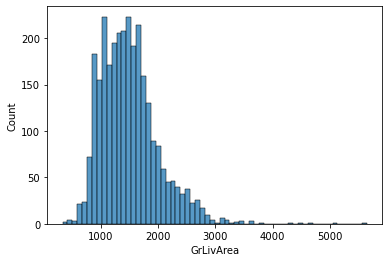

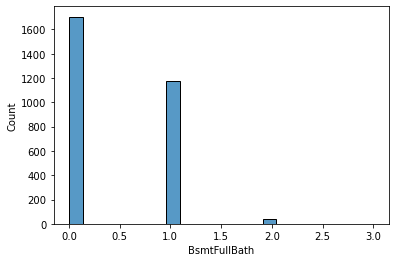

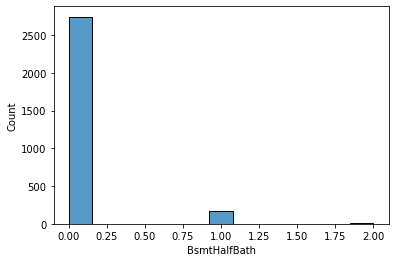

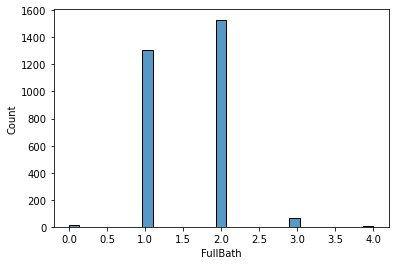

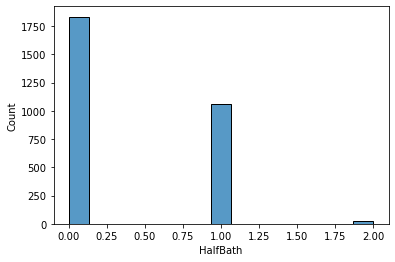

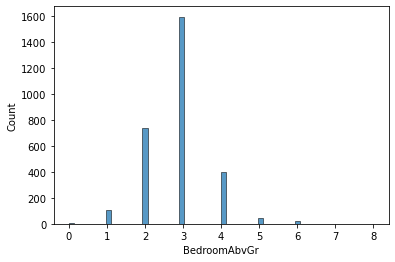

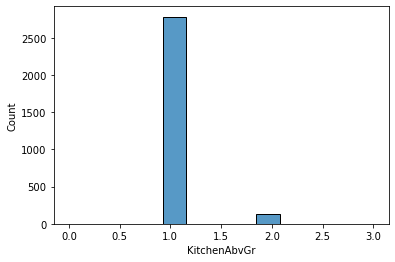

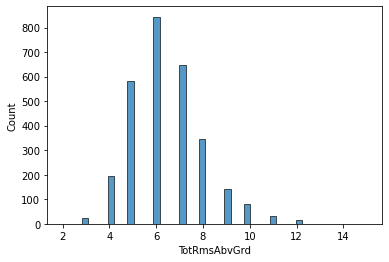

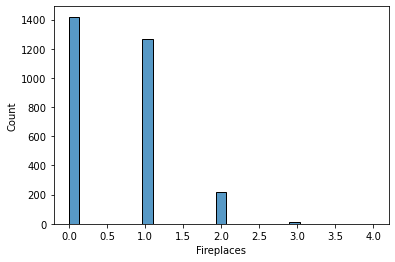

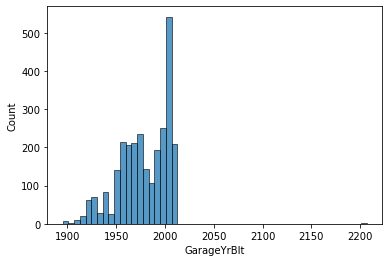

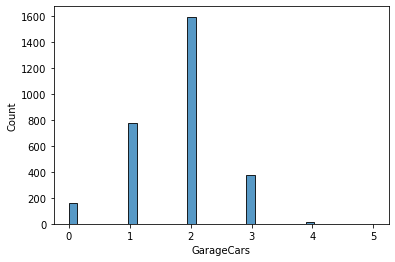

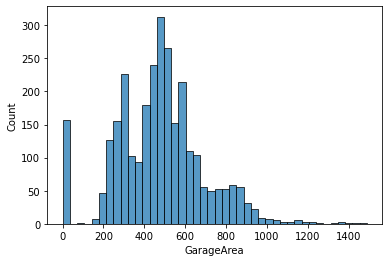

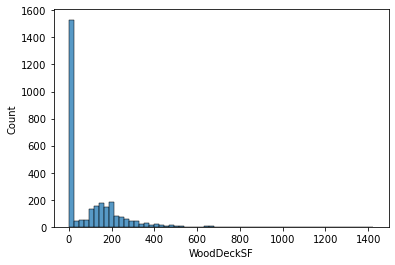

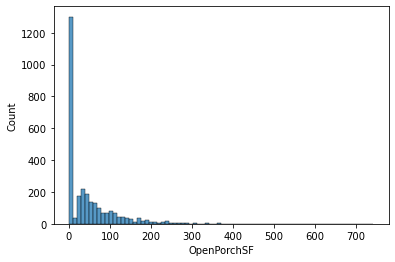

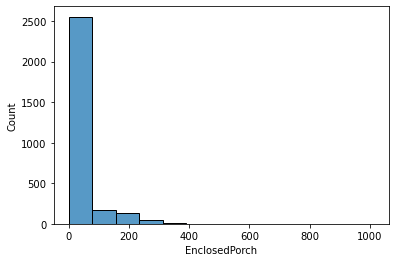

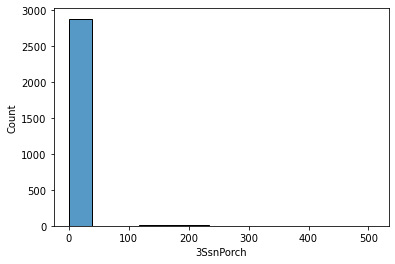

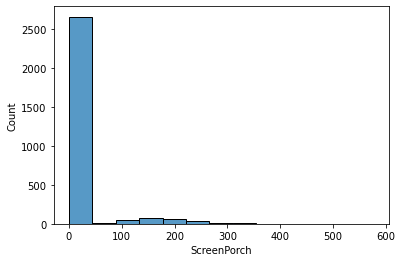

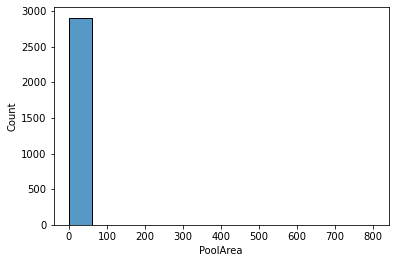

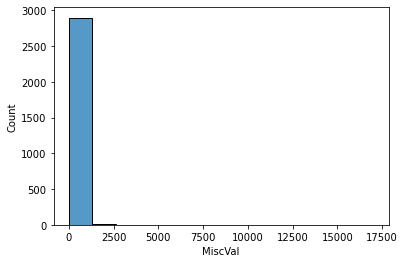

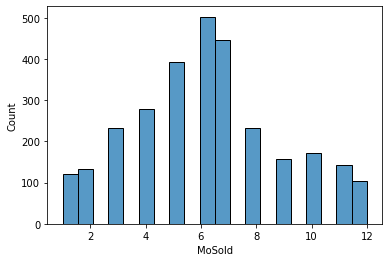

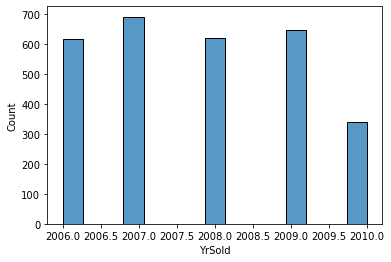

In [19]:
# plotting distribution of numeric columns
for i in num_cols.columns[1:]: # plots all columns except Id
    #sns.distplot(num_cols[i], kde=True) # distribution plots view
    sns.histplot(num_cols[i]) # histogram view
    plt.show()

##### LotFrontage, LotArea, MasVnrArea,BsmtFinSF1, BsmtFinSF2, TotalBsmtSF, 1stFlrSF, GrLivArea, GarageArea columns had skewed distribution; may require log transformation

# Bi-variate plots 

checking distribution of numberic cols vs SalePrice from only train_df because test_df doesn't have SalePrice column; this shows what features are linearly related with target feature (SalePrice).

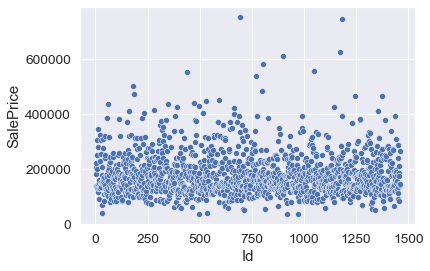

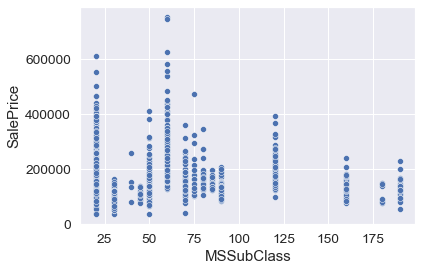

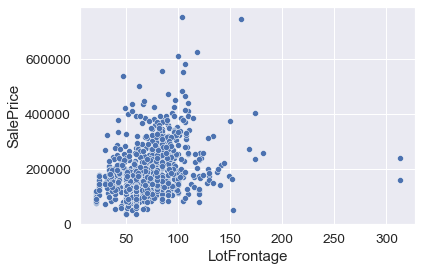

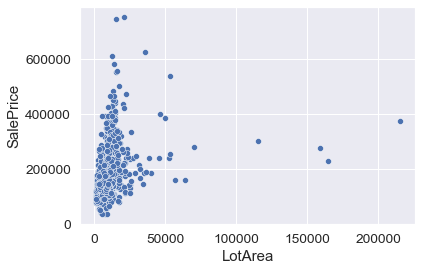

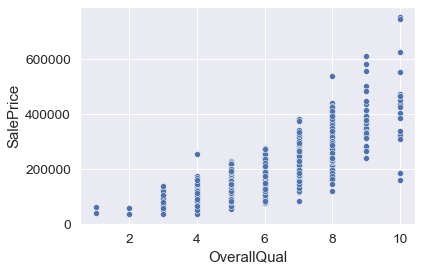

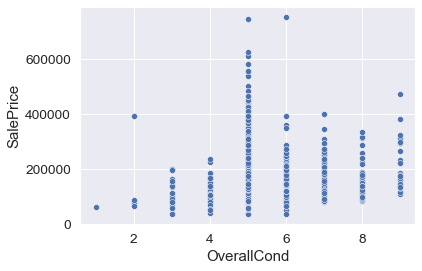

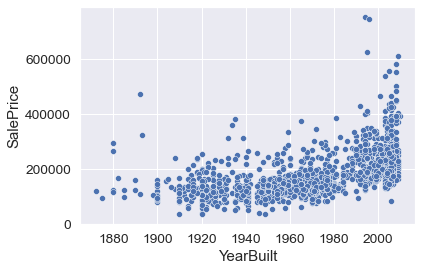

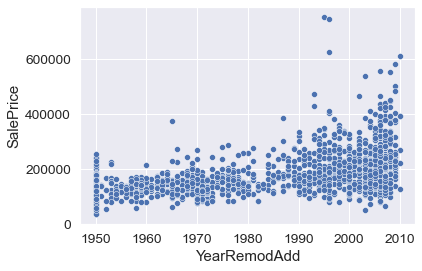

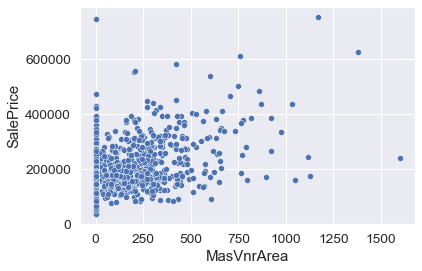

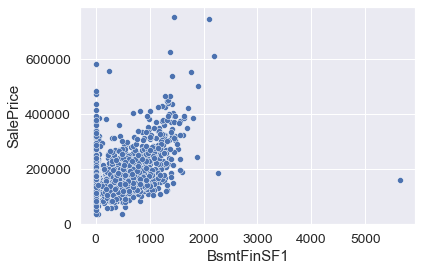

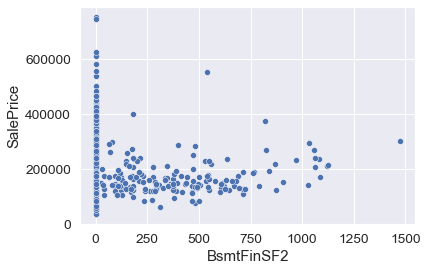

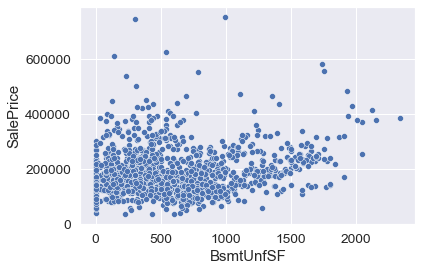

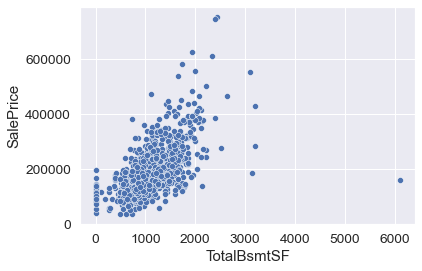

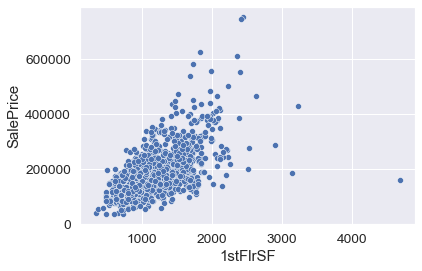

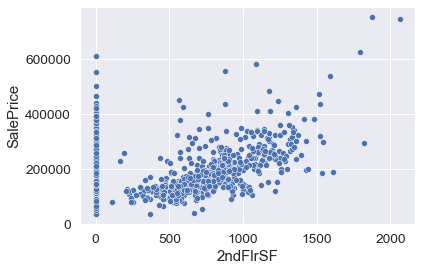

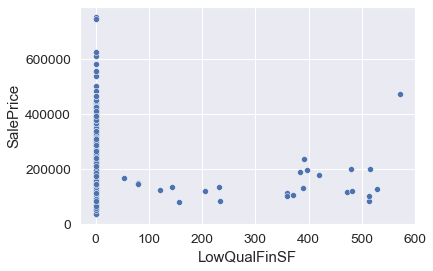

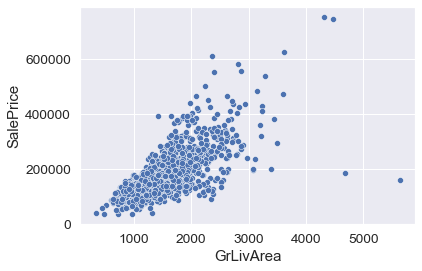

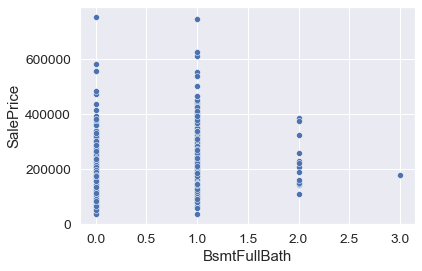

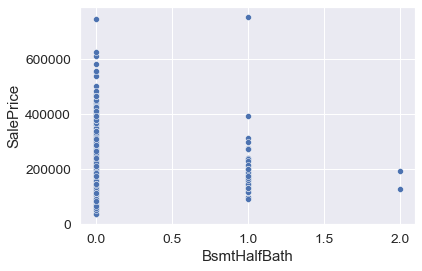

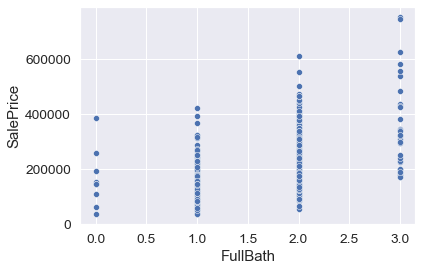

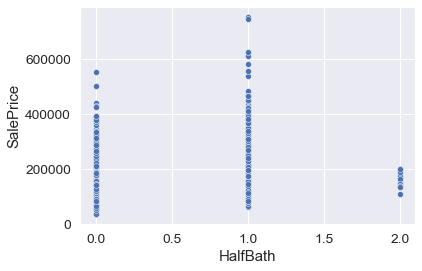

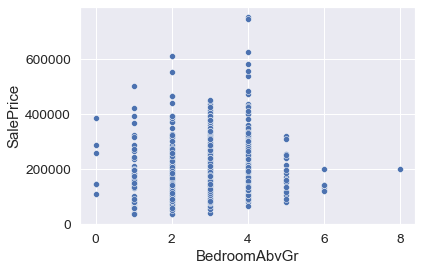

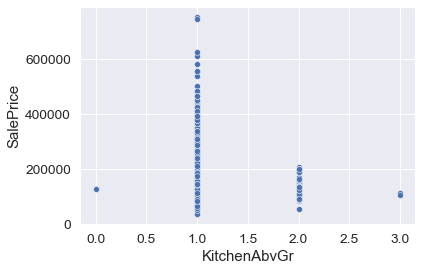

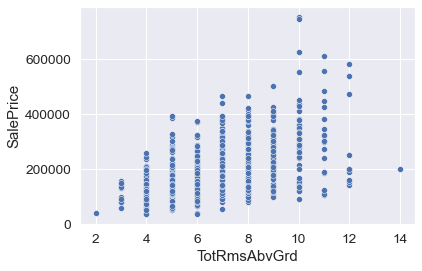

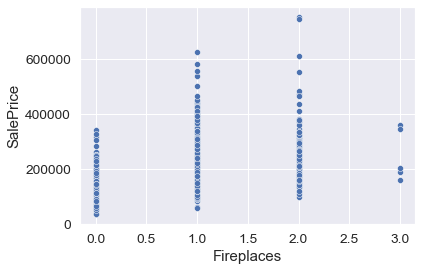

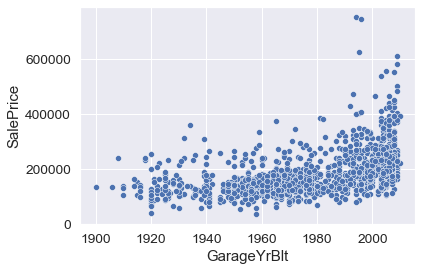

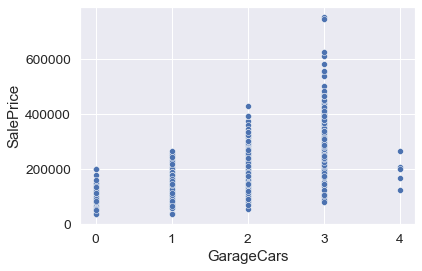

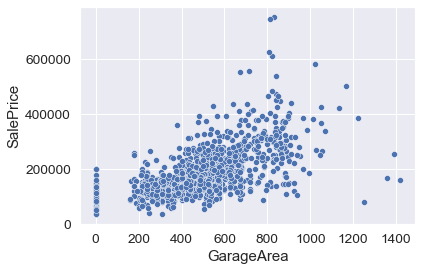

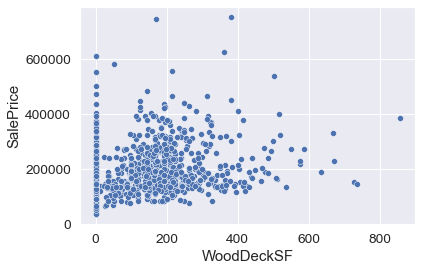

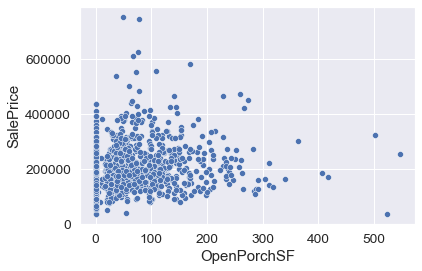

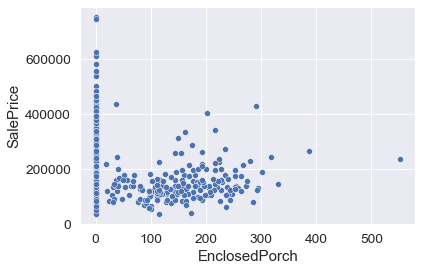

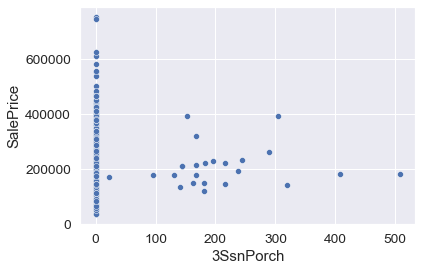

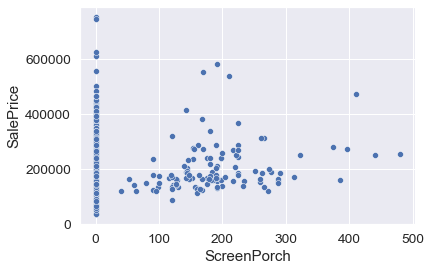

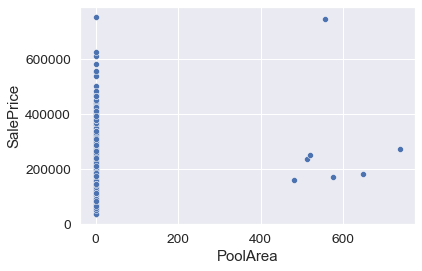

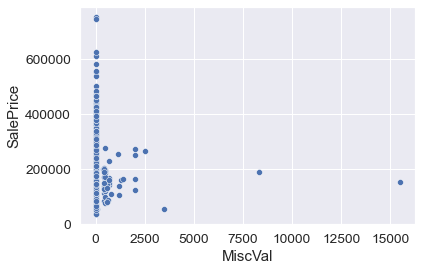

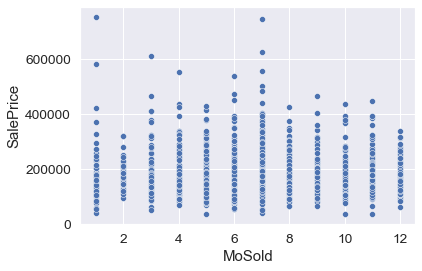

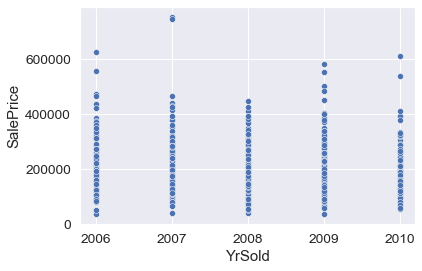

In [468]:
# Scatter plots used for Bi-variate analysis; is recommended
for i in num_cols[1:]:
    #print(num_cols[i])
    sns.scatterplot(x=train_df[i], y=train_df['SalePrice'])
    plt.show()

18


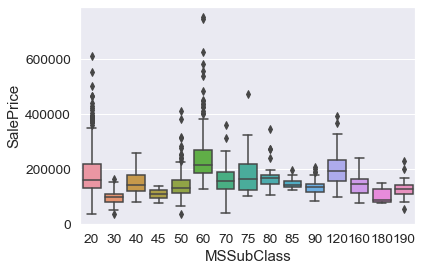

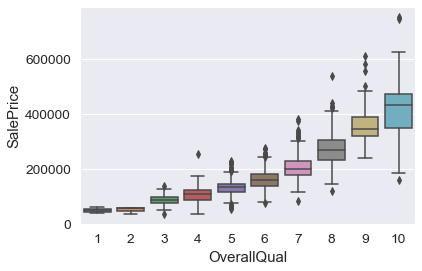

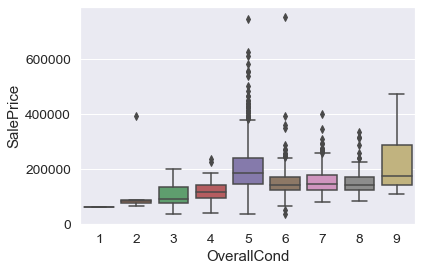

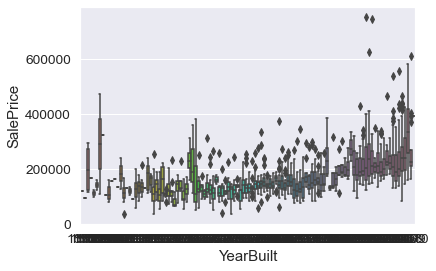

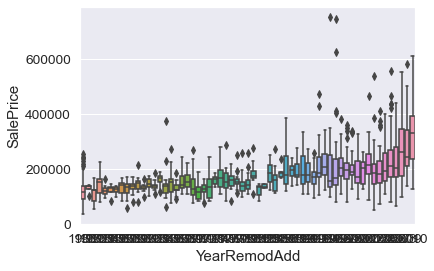

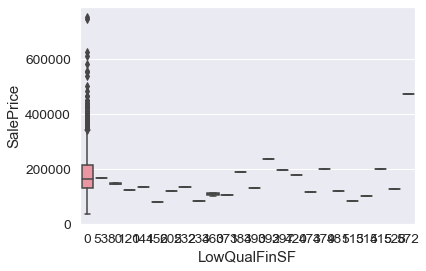

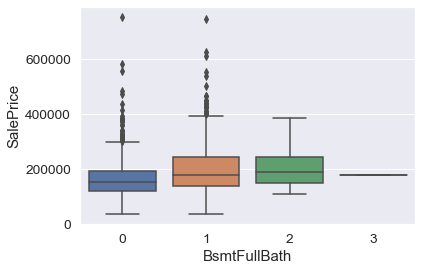

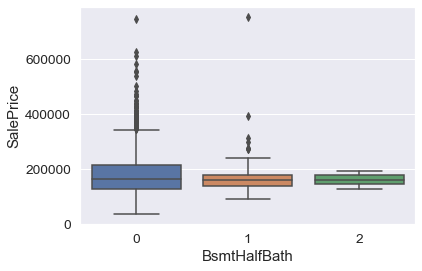

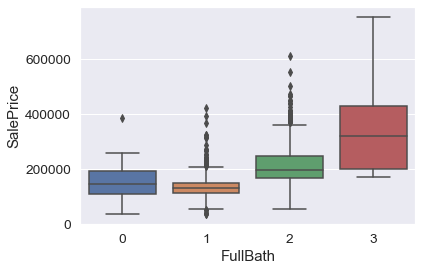

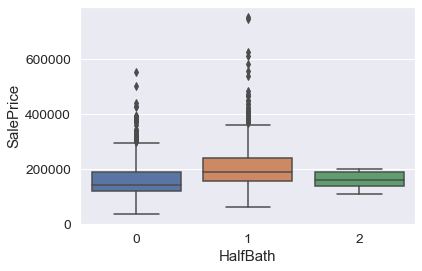

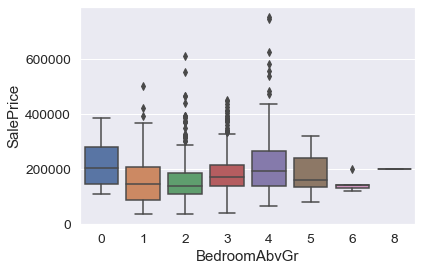

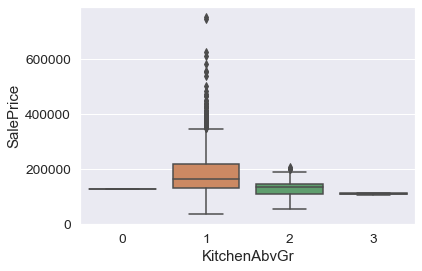

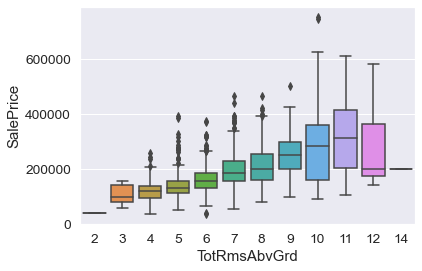

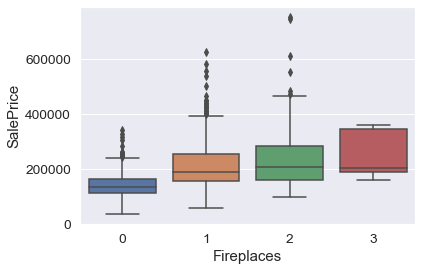

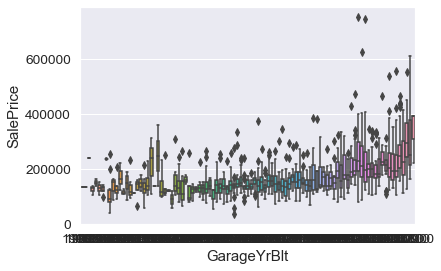

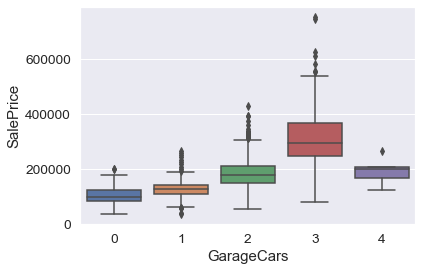

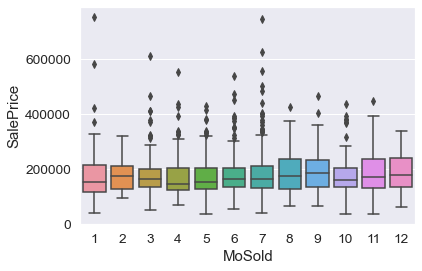

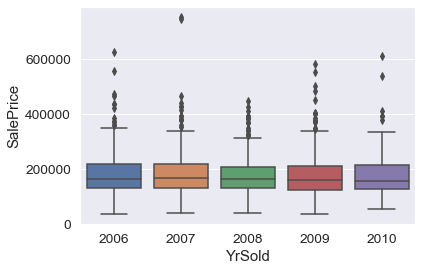

In [469]:
cols=['MSSubClass', 'OverallQual','OverallCond','YearBuilt','YearRemodAdd','LowQualFinSF','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','MoSold','YrSold']
print(len(cols))
for i in cols:
    sns.boxplot(x=train_df[i], y=train_df['SalePrice'])
    plt.show()

### MSSubClass had several discreate values; so creating a new feature by grouping the values

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

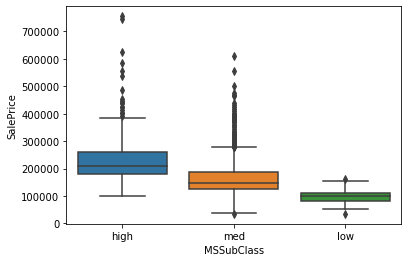

In [20]:
train_df = train_df.replace({"MSSubClass": {60: 'high', 120: 'high', 30: 'low', 45:'low', 20:'med', 40:'med',50:'med',70:'med',75: 'med',80:'med',85:'med',90: 'med',160: 'med',180:'med',190:'med'}}) 
train_df.head()  
sns.boxplot(x=train_df["MSSubClass"], y=train_df['SalePrice'])


In [471]:
df = df.replace({"MSSubClass": {60: 'high', 120: 'high', 30: 'low', 45:'low', 20:'med', 40:'med',50:'med',70:'med',75: 'med',80:'med',85:'med',90: 'med',160: 'med',180:'med',190:'med'}}) 
df.head()                                           

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,high,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,med,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,high,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,med,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,high,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [472]:
df['MSSubClass'].value_counts()

med     2004
high     757
low      157
150        1
Name: MSSubClass, dtype: int64

# 2.2 Categorical Variables

In [473]:
cat_fea=df.select_dtypes(include='object')
cat_fea.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,high,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,med,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,high,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,med,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,high,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


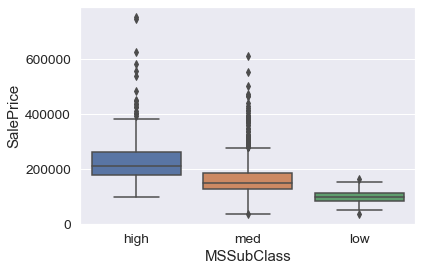

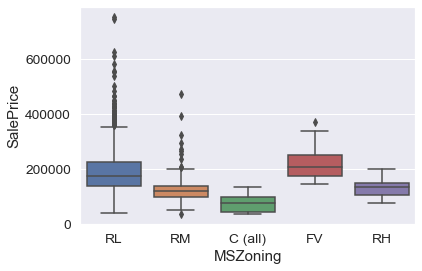

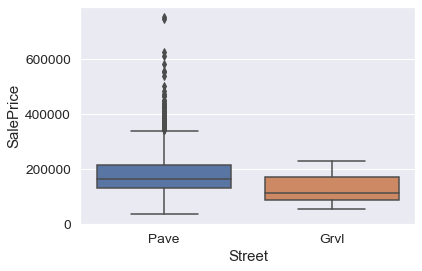

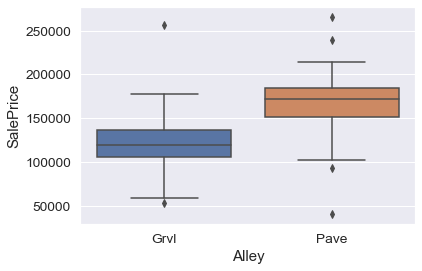

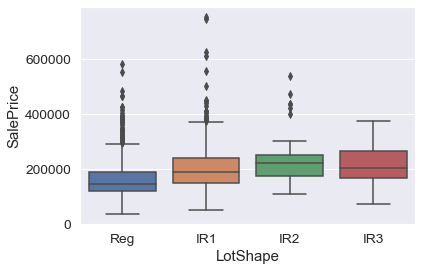

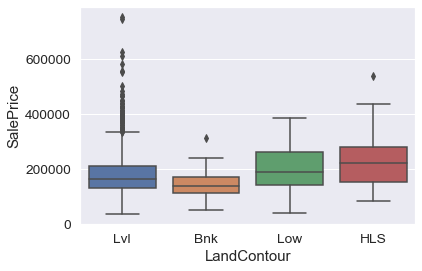

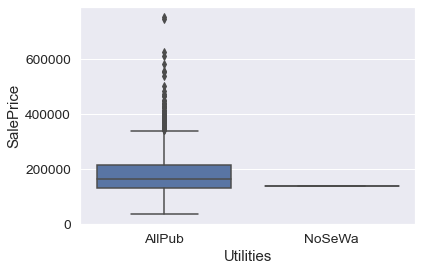

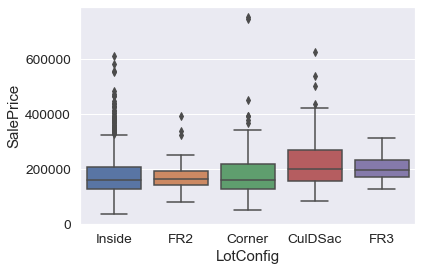

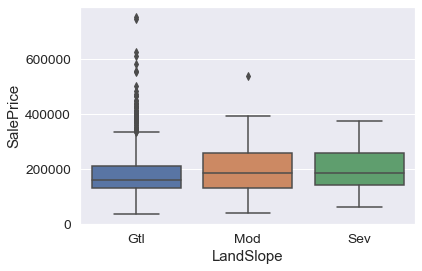

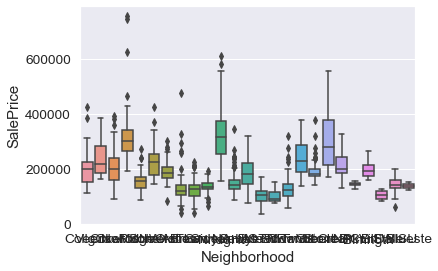

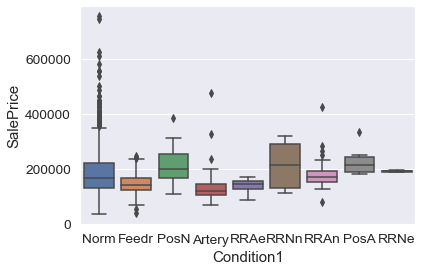

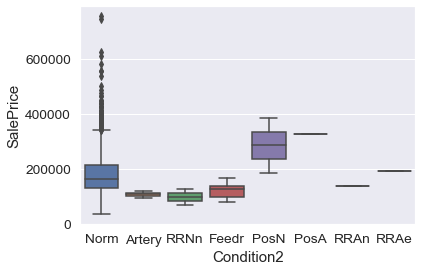

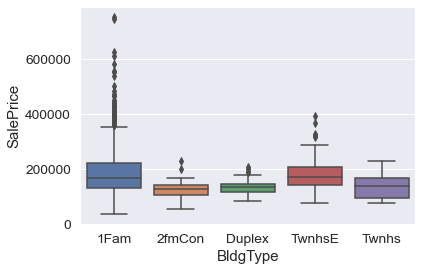

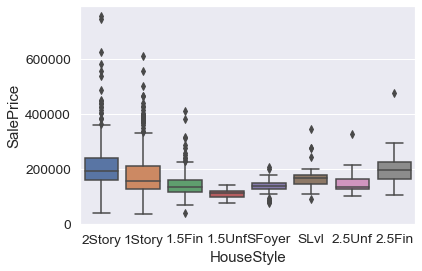

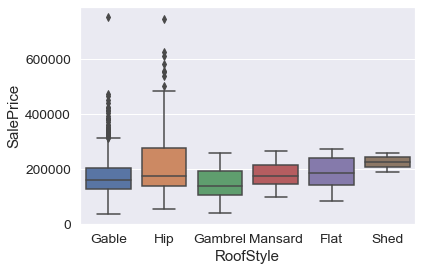

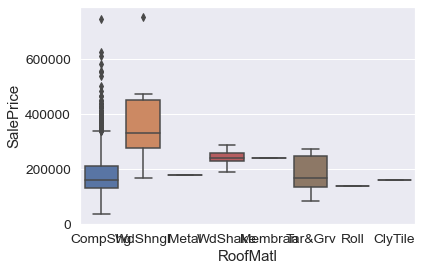

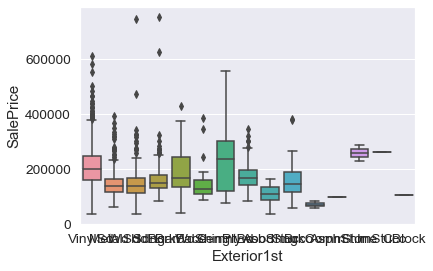

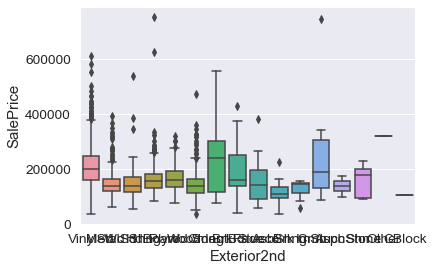

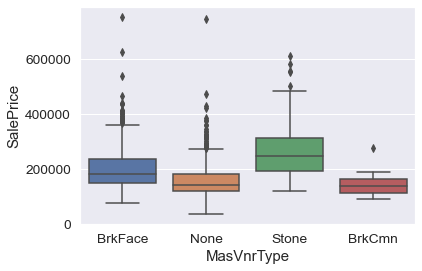

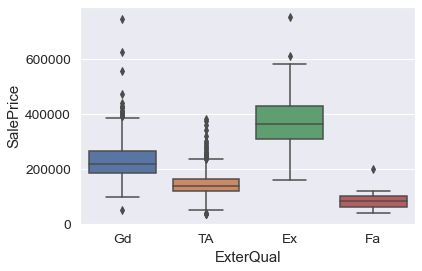

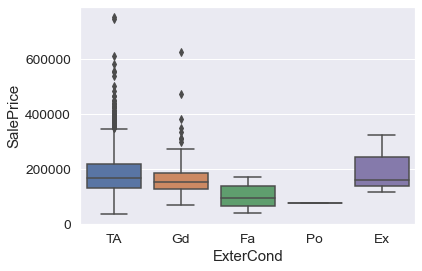

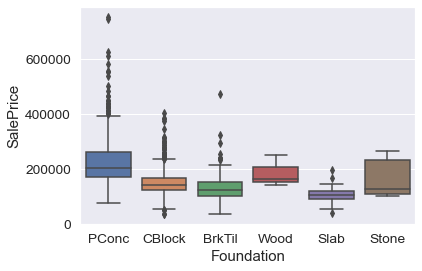

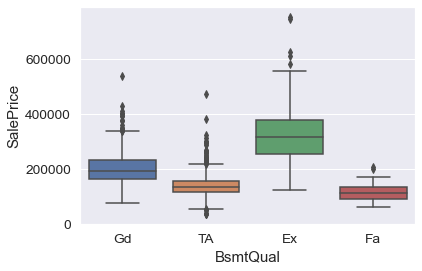

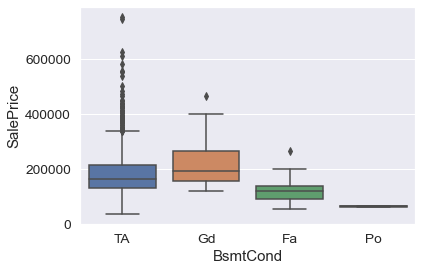

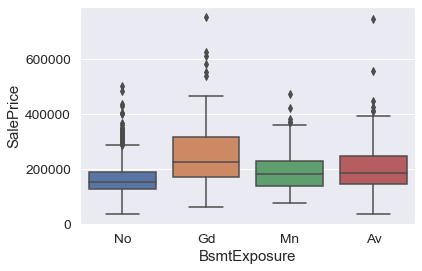

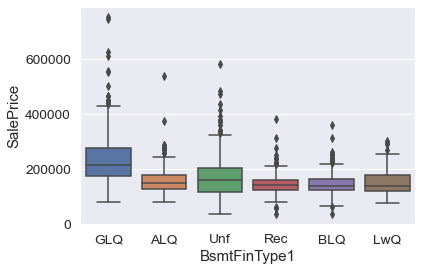

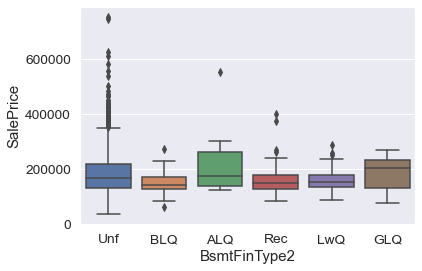

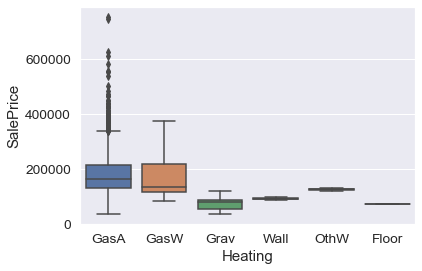

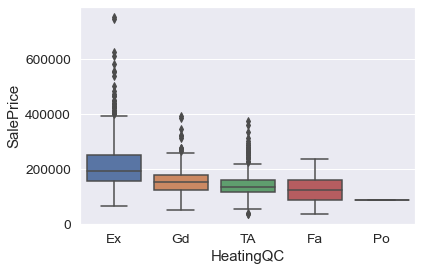

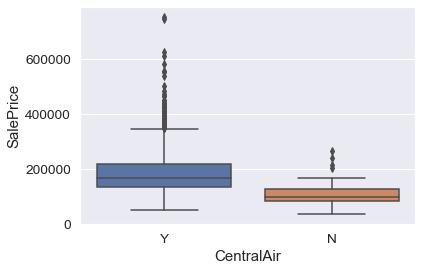

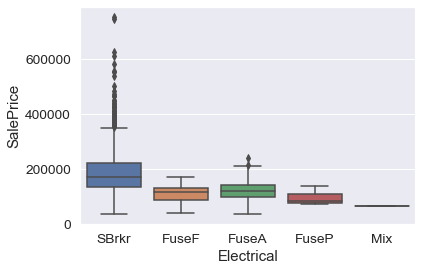

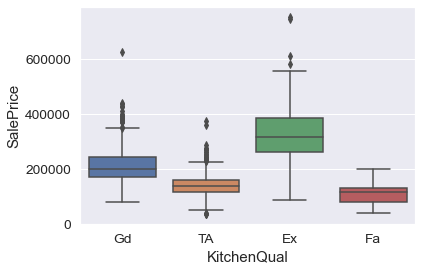

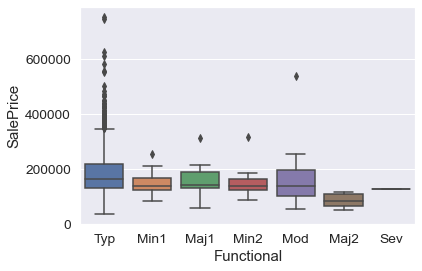

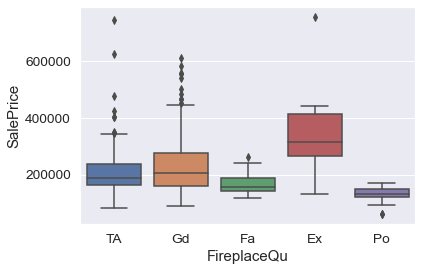

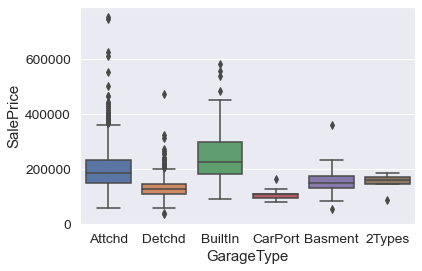

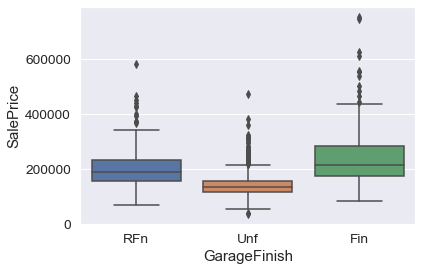

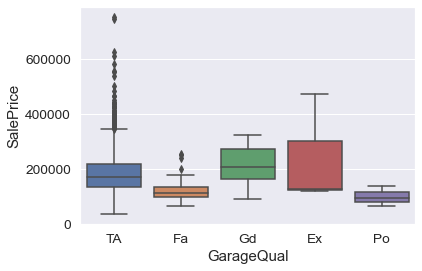

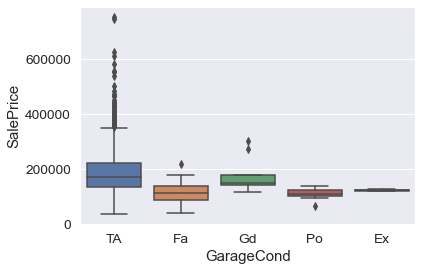

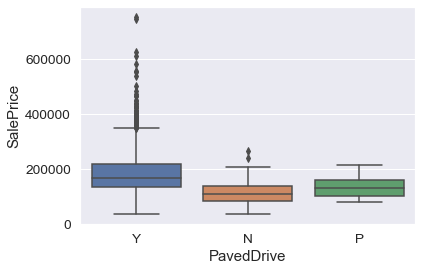

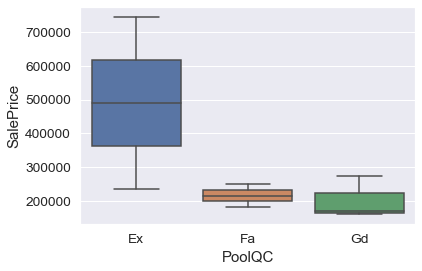

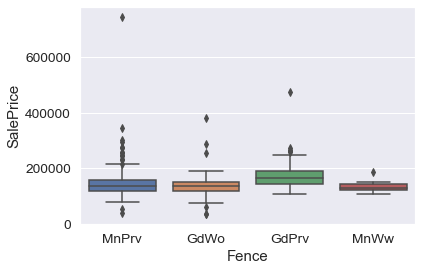

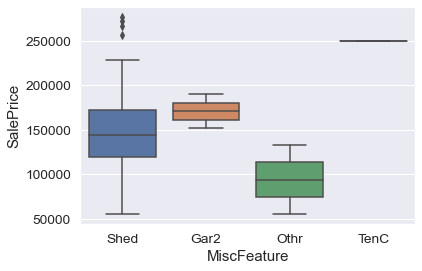

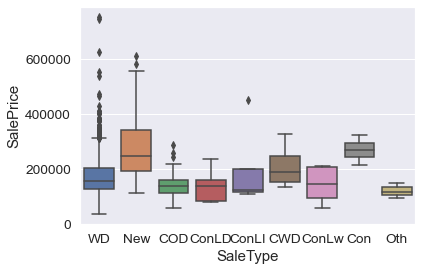

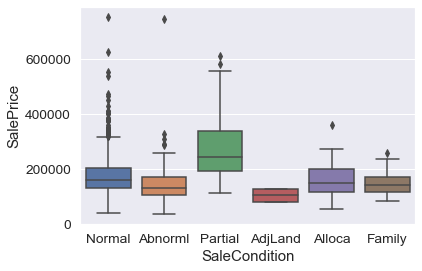

In [474]:
for j in cat_fea:
    sns.boxplot(x=train_df[j], y=train_df['SalePrice'])
    plt.show()

# 2.3 Correlation matrix with df (note SalePrice fea is not there)

<AxesSubplot:>

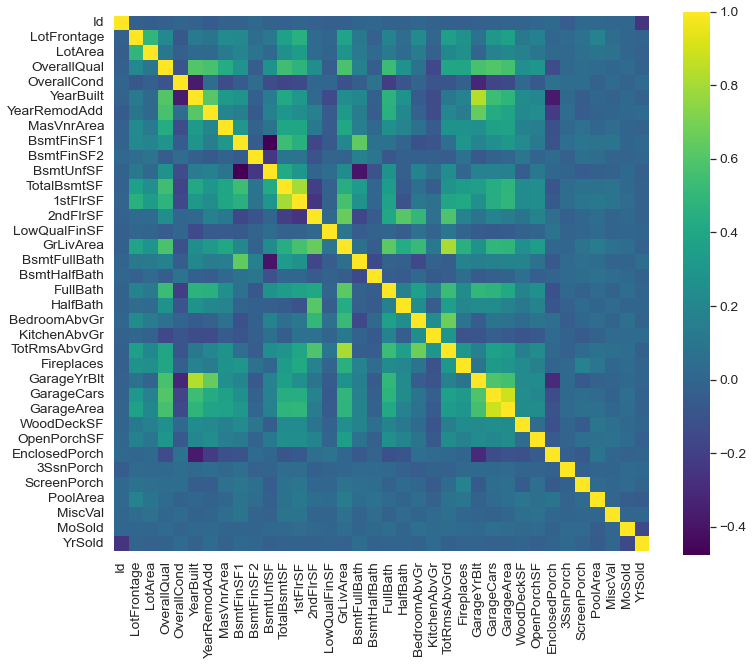

In [475]:
df_corr_mat=df.corr()
f,ax=plt.subplots(figsize=(12,10))
sns.heatmap(df_corr_mat, cmap='viridis', square=True)

# 2.3 Correlation matrix with train_df since we want to see correlation of features with SalePrice to determine predictive features

<AxesSubplot:>

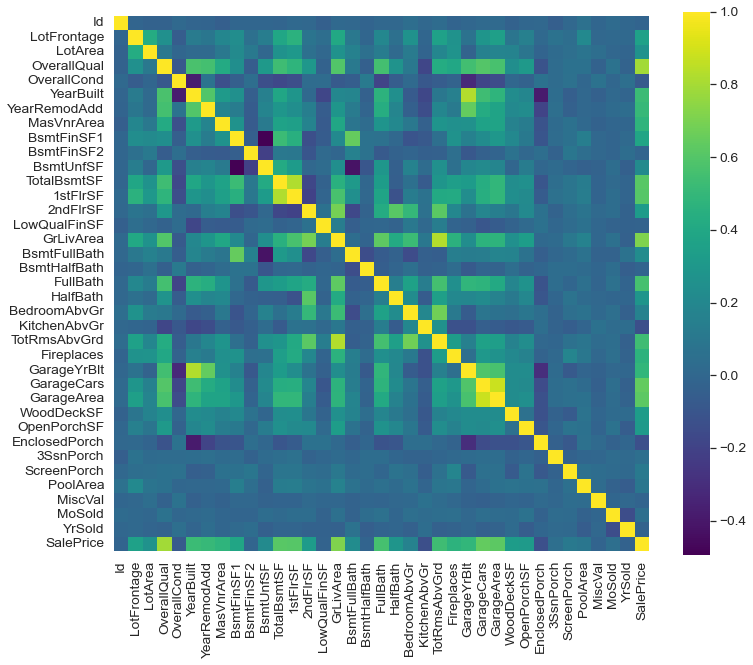

In [476]:
corr_mat=train_df.corr()
f,ax=plt.subplots(figsize=(12,10))
sns.heatmap(corr_mat, cmap='viridis', square=True)

# 2.4 Plot top 10 correlated features with values

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')


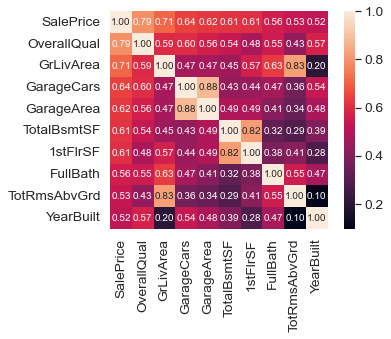

In [477]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corr_mat.nlargest(k, 'SalePrice')['SalePrice'].index
print(cols)
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Summary: OverallQual, GrLivArea are more correlated with SalePrice. GarageCars and GarageArea seems to be colinear features, will have same info means # of cars fit in Garage depends on Garage Size. So, keep only GarageCars column. Similary, TotalBsmtSF and 1stFlrSF are coliniear, keep TotalBsmtSF column. FullBath, TotRmsAbvGrd, Year Built seem correlated with Sale price

In [23]:
# 2.4 Handling missing data in combined df
miss_sum=df.isnull().sum()
perc_miss=(df.isnull().sum()/df.isnull().count())*100
missing=pd.concat([miss_sum,perc_miss], axis=1, keys=['Sum_of_missing', 'Percent_missing'])
data=missing.reset_index().sort_values(['Percent_missing'], ascending=False).head(35)
data

,index,Sum_of_missing,Percent_missing
72,PoolQC,2909,99.657417
74,MiscFeature,2814,96.402878
6,Alley,2721,93.216855
73,Fence,2348,80.438506
57,FireplaceQu,1420,48.646797
3,LotFrontage,486,16.649538
59,GarageYrBlt,159,5.447071
60,GarageFinish,159,5.447071
63,GarageQual,159,5.447071
64,GarageCond,159,5.447071


### Consider removing features with >23 missing values. Also, these are not important features determining house prices. All the garage features except GarageCars had ~5% similar missing data, since GarageCars had less missing data and useful info, I am keeping this column and remove rest of the Garage features. Similarly, keep BsmtSF and remove (BsmtFinType2, BsmtExposure, BsmtQual, BsmtCond, BsmtFinType1 features). MasVnrArea and MasVnrType are not important features, so dropping them doesn't hurt. Finally, some feature had just 1 missing value, so I am dropping those rows instead of entire column.

## 2.4 Summary of handling missing data: Dropping all features with >23 missing values from df and train_df.

In [25]:
print(list(data['index'][:18])) # slice features with high missing data
cols_drop=list(data['index'][:18])
data_set=df.drop(df[cols_drop], axis=1)
data_set.head()

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType', 'MasVnrArea']


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal


In [26]:
# drop rows with missing values (since some features had only 1-4 missing values, so dropping rows instead of entire column)
data_set=data_set.dropna()
# Making sure no missing data exist
data_set.isnull().sum().sort_values(ascending=False).head()

Id            0
Functional    0
Electrical    0
1stFlrSF      0
2ndFlrSF      0
dtype: int64

In [27]:
data_set.shape

(2906, 62)

In [28]:
print(list(data['index'][:18])) # slice features with high missing data
cols_drop=list(data['index'][:18])
train_data_set=train_df.drop(train_df[cols_drop], axis=1)
train_data_set=train_data_set.dropna()
train_data_set.head()

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType', 'MasVnrArea']


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,high,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,med,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,high,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,med,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,high,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [29]:
# Making sure no missing data exist
train_data_set.isnull().sum().sort_values(ascending=False).head()

Id              0
Fireplaces      0
1stFlrSF        0
2ndFlrSF        0
LowQualFinSF    0
dtype: int64

In [30]:
train_data_set.shape

(1459, 63)

# 2.5 Handling Outliers
## 2.5.1 Univariate plot

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

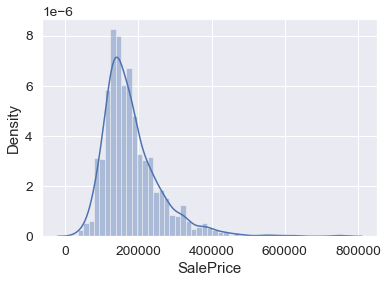

In [485]:
sns.distplot(train_data_set.SalePrice) ## since train_data_set contains SalePrice column

# 2.5.2 Bivariate plots with key features
## 2.5.2.1 Detect and drop Outliers from key features

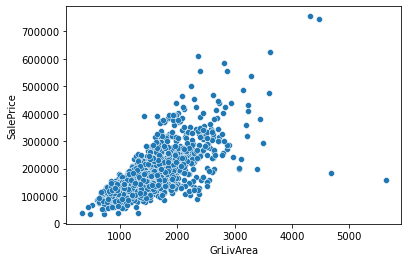

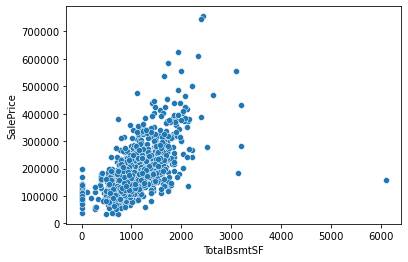

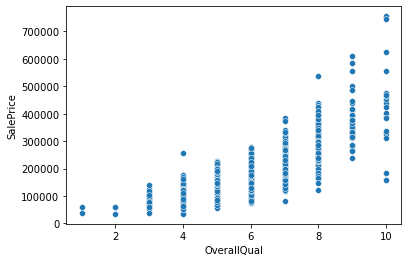

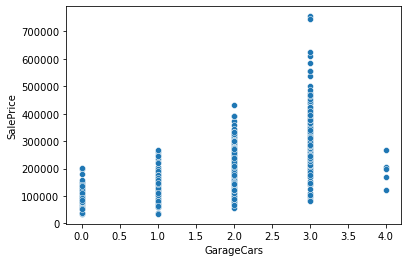

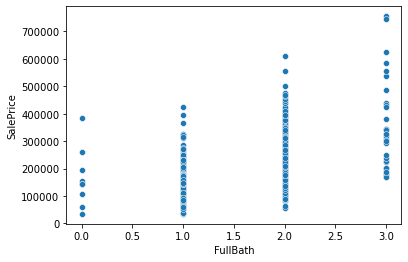

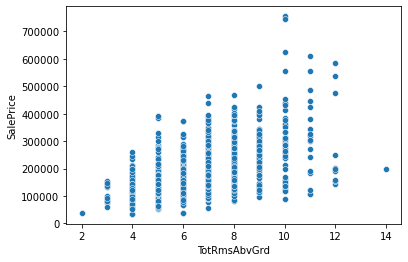

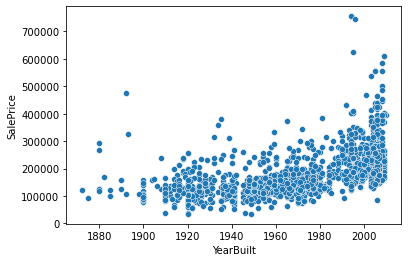

In [32]:
# top features from corr_matrix
key_features=['GrLivArea','TotalBsmtSF','OverallQual','GarageCars','FullBath', 'TotRmsAbvGrd', 'YearBuilt']
for i in key_features:
    sns.scatterplot(x=train_data_set[i], y=train_data_set['SalePrice'])
    #sns.boxplot(x=train_data_set[i], y=train_data_set['SalePrice'])
    plt.show()

# Drop outliers from combined df, and train_df

In [487]:
# slice outlier values
train_data_set.loc[(train_data_set['GrLivArea']>4000) & (train_data_set['SalePrice']<185000)]['GrLivArea']

523     4676
1298    5642
Name: GrLivArea, dtype: int64

In [488]:
# drop rows with GrLivArea >4000 but SalePrice <185000 to keep top outliers
train_df1 = train_data_set.drop(train_data_set
                   [(train_data_set['GrLivArea']>4000) & (train_data_set['SalePrice']<185000)].index)

train_df1.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,high,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,med,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,high,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,med,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,high,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [489]:
print(train_data_set.shape)
print(train_df1.shape)

(1459, 63)
(1457, 63)


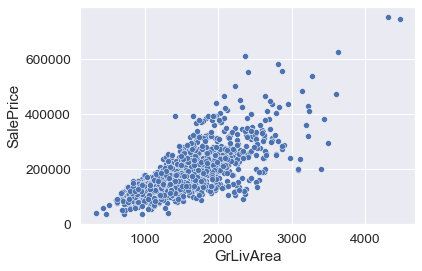

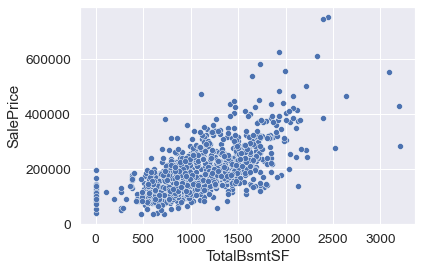

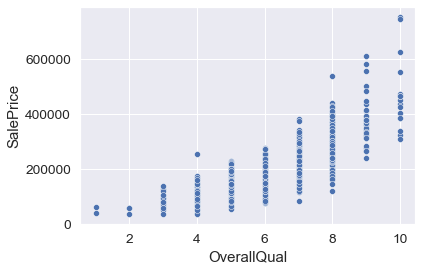

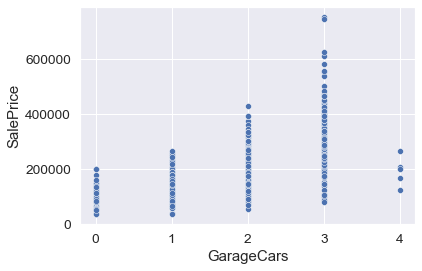

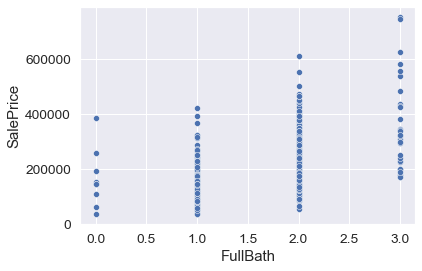

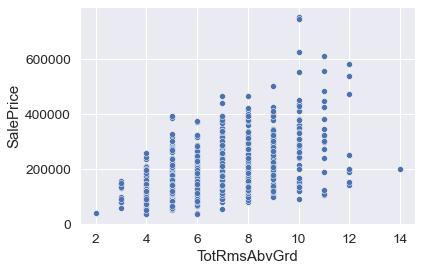

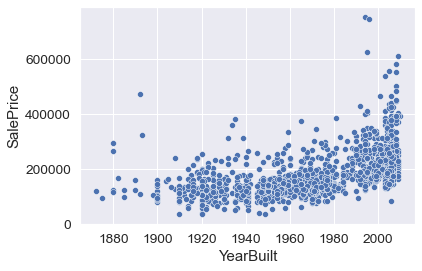

In [490]:
## making sure if outliers are removed from key features of train_df
key_features=['GrLivArea','TotalBsmtSF','OverallQual','GarageCars','FullBath', 'TotRmsAbvGrd', 'YearBuilt']
for i in key_features:
    sns.scatterplot(x=train_df1[i], y=train_df1['SalePrice'])
    plt.show()

# drop outlier GrLivArea from combined_df

In [491]:
# find outlier rows in combined df
data_set.loc[data_set['GrLivArea']>=4500]['GrLivArea']

523     4676
1298    5642
1089    5095
Name: GrLivArea, dtype: int64

In [492]:
# but drop only rows with GrLivArea== 4676 and 5642 from combined df
full_df1 = data_set.drop([data_set.index[523], data_set.index[1298]])
full_df1.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,high,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,2,med,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,3,high,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,4,med,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,5,high,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal


In [493]:
print(data_set.shape)
print(full_df1.shape) # 4 rows are dropped two from train_df, 2 from test_df

(2906, 62)
(2902, 62)


# 3. Preprocessing
## 3.1 check distribution of target variable

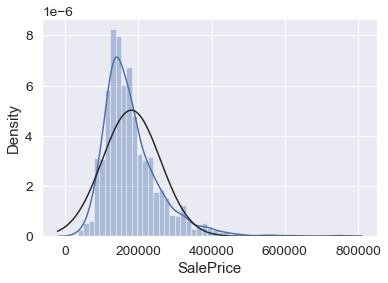

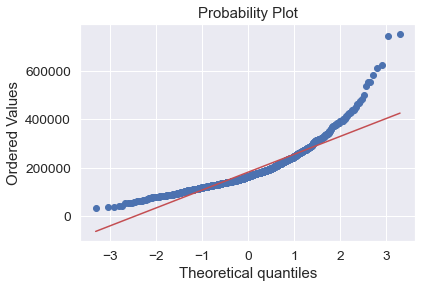

In [494]:
# histogram and probability plot of target variable
sns.distplot(target['SalePrice'], fit=norm)
fig=plt.figure()
res=stats.probplot(target['SalePrice'], plot=plt)

## SalePrice is not normally distributed, and had positive skewness. So, apply log transformation

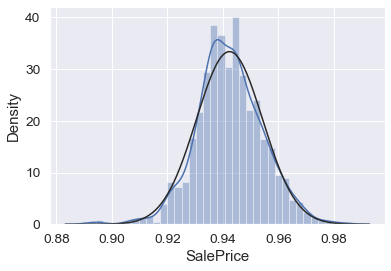

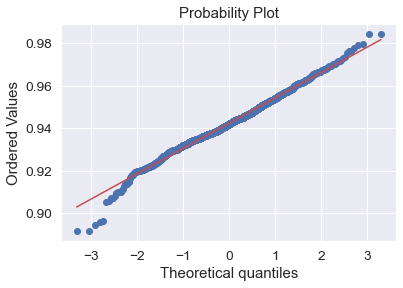

In [546]:
# apply log transformation to target variable to make normally distributed
target['SalePrice']=np.log(target['SalePrice'])

# check if log transformation improved histogram and prob distribution
sns.distplot(target['SalePrice'], fit=norm)
fig=plt.figure()
res=stats.probplot(target['SalePrice'], plot=plt)

## Yes, target variable is normally distributed........

## Similarly, check distribution of SalePrice from train_df1

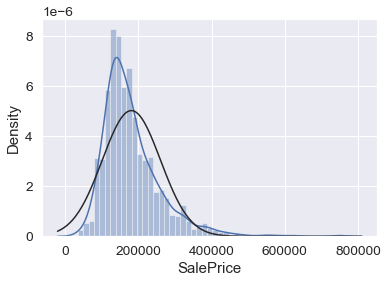

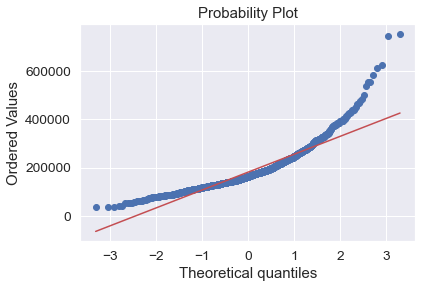

In [496]:
# histogram and probability plot of target variable
sns.distplot(train_df1['SalePrice'], fit=norm)
fig=plt.figure()
res=stats.probplot(train_df1['SalePrice'], plot=plt)

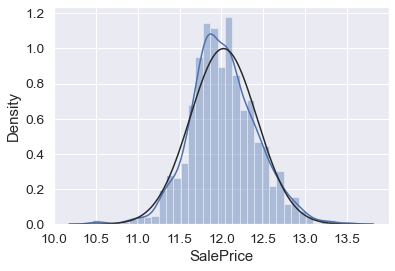

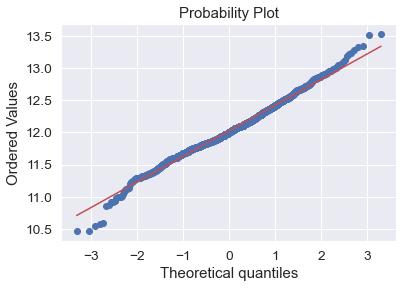

In [497]:
# apply log transformation to target variable to make normally distributed
train_df['SalePrice']=np.log(train_df['SalePrice'])

# check if log transformation improved histogram and prob distribution
sns.distplot(train_df['SalePrice'], fit=norm)
fig=plt.figure()
res=stats.probplot(train_df['SalePrice'], plot=plt)

# 3.2 how about distribution of key features? GrLivArea from full_df1

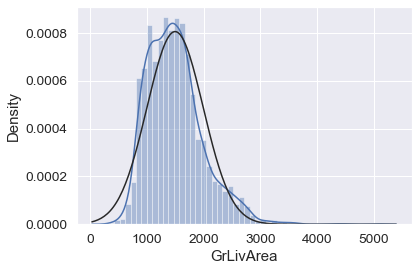

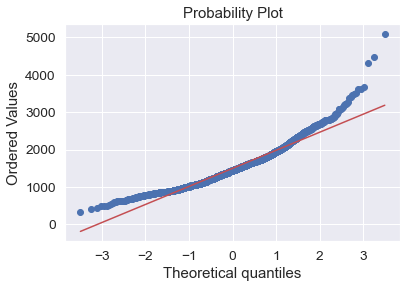

In [498]:
sns.distplot(full_df1['GrLivArea'], fit=norm);
fig=plt.figure()
res=stats.probplot(full_df1['GrLivArea'], plot=plt)

## GrLivArea is not normally distributed, and had positive skewness. So, apply log transformation

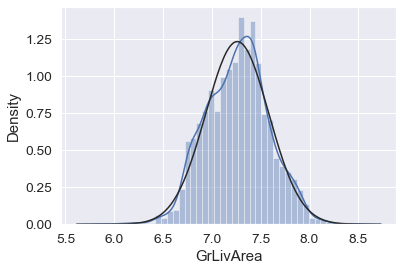

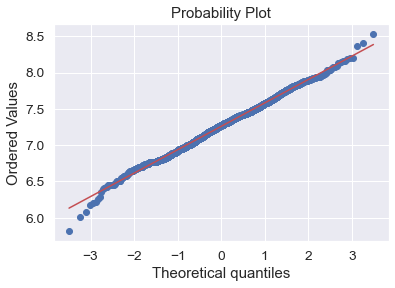

In [499]:
# apply log transformation to variable to make normally distributed
full_df1['GrLivArea'] = np.log(full_df1['GrLivArea'])

# check if log transformation improved histogram and prob distribution
sns.distplot(full_df1['GrLivArea'], fit=norm)
fig=plt.figure()
res=stats.probplot(full_df1['GrLivArea'], plot=plt)

## Now, GrLivArea is normally distributed

## 3.2.1 how about distribution of key features? GrLivArea from train_df1

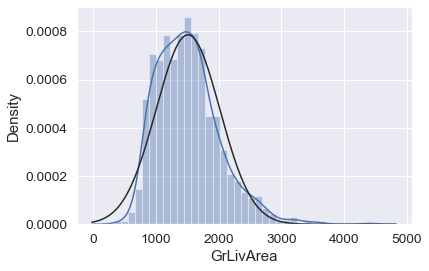

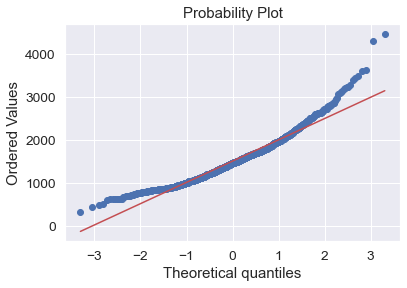

In [500]:
sns.distplot(train_df1['GrLivArea'], fit=norm);
fig=plt.figure()
res=stats.probplot(train_df1['GrLivArea'], plot=plt)

### GrLivArea is not normally distributed, and had positive skewness. So, apply log transformation

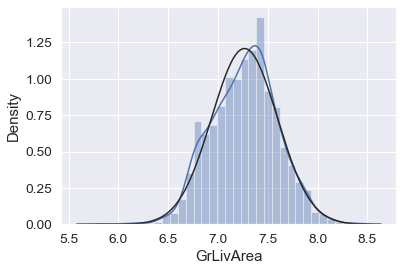

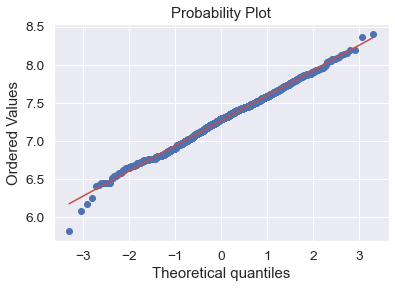

In [501]:
# apply log transformation to variable to make normally distributed
train_df1['GrLivArea'] = np.log(train_df1['GrLivArea'])

# check if log transformation improved histogram and prob distribution
sns.distplot(train_df1['GrLivArea'], fit=norm)
fig=plt.figure()
res=stats.probplot(train_df1['GrLivArea'], plot=plt)

## 3.3 how about distribution of key features? TotalBsmtSF?

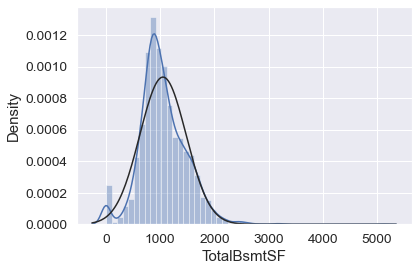

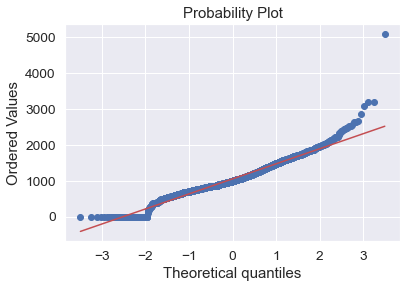

In [502]:
sns.distplot(full_df1['TotalBsmtSF'], fit=norm)
fig=plt.figure()
res=stats.probplot(full_df1['TotalBsmtSF'], plot=plt)

### TotalBsmtSF is not normally distributed had positive skewness. BUT starts with 0 (houses without basement); 0 doesn't allow log transformation;

In [508]:
full_df1.replace([np.inf, -np.inf], 1, inplace=True)

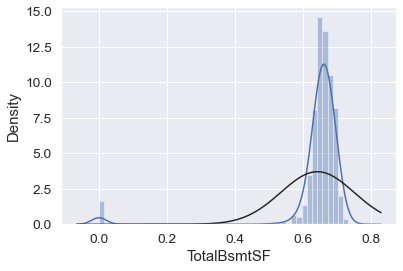

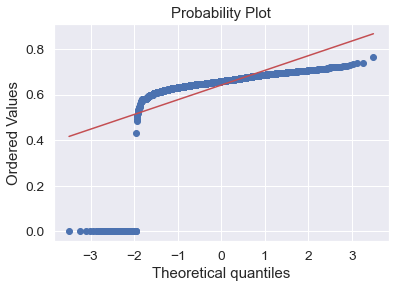

In [509]:
# apply log transformation to variable to make normally distributed
full_df1['TotalBsmtSF']=np.log(full_df1['TotalBsmtSF'])

# check if log transformation improved histogram and prob distribution
sns.distplot(full_df1['TotalBsmtSF'], fit=norm)
fig=plt.figure()
res=stats.probplot(full_df1['TotalBsmtSF'], plot=plt)

In [510]:
full_df1.TotalBsmtSF.isnull().sum()

0

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

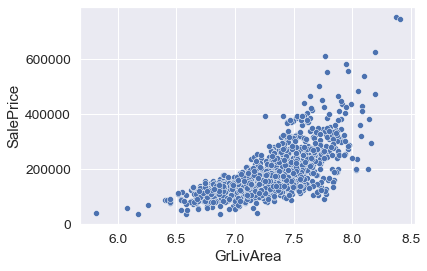

In [511]:
sns.scatterplot(x=train_df1['GrLivArea'], y=train_df1['SalePrice'])

# Then handling categorical data of df1

In [512]:
# 3.4 Create dummy variables to categorical variables
dummies=pd.get_dummies(full_df1)
dummies.head()

,Id,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,8450,7,5,2003,2003,706.0,0.0,150.0,0.647040,...,0,0,0,1,0,0,0,0,1,0
1,2,9600,6,8,1976,1976,978.0,0.0,284.0,0.675887,...,0,0,0,1,0,0,0,0,1,0
2,3,11250,7,5,2001,2002,486.0,0.0,434.0,0.652586,...,0,0,0,1,0,0,0,0,1,0
3,4,9550,7,5,1915,1970,216.0,0.0,540.0,0.637269,...,0,0,0,1,1,0,0,0,0,0
4,5,14260,8,5,2000,2000,655.0,0.0,490.0,0.668884,...,0,0,0,1,0,0,0,0,1,0


In [513]:
#check if column contains infinite value, replaced the +/-inf values into nan's and droped rows with nan's
dummies.replace([np.inf, -np.inf], 1, inplace=True)
dummies.dropna()
dummies.shape

(2902, 223)

In [514]:
# check if any missing values in features after preprocessing
dummies.isnull().sum().sort_values(ascending=False)

Id                       0
Exterior2nd_MetalSd      0
Exterior1st_VinylSd      0
Exterior1st_Wd Sdng      0
Exterior1st_WdShing      0
                        ..
Neighborhood_NridgHt     0
Neighborhood_OldTown     0
Neighborhood_SWISU       0
Neighborhood_Sawyer      0
SaleCondition_Partial    0
Length: 223, dtype: int64

# Breaking dummies into train and test datasets

In [515]:
dummies=dummies.sort_values(by='Id')
dummies.head(100)

,Id,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,8450,7,5,2003,2003,706.0,0.0,150.0,0.647040,...,0,0,0,1,0,0,0,0,1,0
1,2,9600,6,8,1976,1976,978.0,0.0,284.0,0.675887,...,0,0,0,1,0,0,0,0,1,0
2,3,11250,7,5,2001,2002,486.0,0.0,434.0,0.652586,...,0,0,0,1,0,0,0,0,1,0
3,4,9550,7,5,1915,1970,216.0,0.0,540.0,0.637269,...,0,0,0,1,1,0,0,0,0,0
4,5,14260,8,5,2000,2000,655.0,0.0,490.0,0.668884,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,9765,6,8,1993,1993,310.0,0.0,370.0,0.628713,...,0,0,0,1,0,0,0,0,1,0
96,97,10264,7,5,1999,1999,1162.0,0.0,426.0,0.691871,...,0,0,0,1,0,0,0,0,1,0
97,98,10921,4,5,1965,1965,520.0,0.0,440.0,0.655818,...,0,0,0,1,0,0,0,0,1,0
98,99,10625,5,5,1920,1950,108.0,0.0,350.0,0.594809,...,0,0,0,0,1,0,0,0,0,0


In [516]:
count = np.isinf(dummies).values.sum()
count

0

In [517]:
train_data_ML=dummies.loc[dummies.Id<=1460]
train_data_ML.tail()

,Id,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1455,1456,7917,6,5,1999,2000,0.0,0.0,953.0,0.655264,...,0,0,0,1,0,0,0,0,1,0
1456,1457,13175,6,6,1978,1988,790.0,163.0,589.0,0.689868,...,0,0,0,1,0,0,0,0,1,0
1457,1458,9042,7,9,1941,2006,275.0,0.0,877.0,0.669327,...,0,0,0,1,0,0,0,0,1,0
1458,1459,9717,5,6,1950,1996,49.0,1029.0,0.0,0.664469,...,0,0,0,1,0,0,0,0,1,0
1459,1460,9937,5,6,1965,1965,830.0,290.0,136.0,0.675548,...,0,0,0,1,0,0,0,0,1,0


# Establish test dataset, test numpy array for ML models

In [518]:
test_data_ML=dummies.loc[dummies.Id>=1461]
test_data_ML.head(5)

,Id,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,11622,5,6,1961,1961,468.0,144.0,270.0,0.649352,...,0,0,0,1,0,0,0,0,1,0
1,1462,14267,6,6,1958,1958,923.0,0.0,406.0,0.679552,...,0,0,0,1,0,0,0,0,1,0
2,1463,13830,5,5,1997,1998,791.0,0.0,137.0,0.653246,...,0,0,0,1,0,0,0,0,1,0
3,1464,9978,6,6,1998,1998,602.0,0.0,324.0,0.653081,...,0,0,0,1,0,0,0,0,1,0
4,1465,5005,8,5,1992,1992,263.0,0.0,1017.0,0.676895,...,0,0,0,1,0,0,0,0,1,0


In [519]:
test_array=test_data_ML.values
print(test_array[:20])

[[1.4610e+03 1.1622e+04 5.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [1.4620e+03 1.4267e+04 6.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [1.4630e+03 1.3830e+04 5.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 ...
 [1.4780e+03 1.1520e+04 9.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [1.4790e+03 1.4122e+04 8.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
 [1.4800e+03 1.4300e+04 9.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]]


In [520]:
print(dummies.shape)
print(train_data_ML.shape)
print(test_data_ML.shape)
print(test_array.shape)

(2902, 223)
(1457, 223)
(1445, 223)
(1445, 223)


## Adding log transformed SalePrice col from target to train_df1_ML

In [521]:
train_data=pd.merge(train_data_ML, target, on='Id')
train_data.head()

,Id,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1,8450,7,5,2003,2003,706.0,0.0,150.0,0.647040,...,0,0,1,0,0,0,0,1,0,12.247694
1,2,9600,6,8,1976,1976,978.0,0.0,284.0,0.675887,...,0,0,1,0,0,0,0,1,0,12.109011
2,3,11250,7,5,2001,2002,486.0,0.0,434.0,0.652586,...,0,0,1,0,0,0,0,1,0,12.317167
3,4,9550,7,5,1915,1970,216.0,0.0,540.0,0.637269,...,0,0,1,1,0,0,0,0,0,11.849398
4,5,14260,8,5,2000,2000,655.0,0.0,490.0,0.668884,...,0,0,1,0,0,0,0,1,0,12.429216


In [522]:
train_data.shape

(1457, 224)

# 4. Train Model
## Separating features (X) and target variable (y)

# split train_data into X, y

In [33]:
X= train_data.iloc[:,:-1].values
y= train_data['SalePrice'].values

KeyError: 'SalePrice'

In [524]:
X.shape

(1457, 223)

In [525]:
y.shape

(1457,)

# Train, Test, split data

In [527]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1019, 223)
(438, 223)
(1019,)
(438,)


# Feature Scaling

In [526]:
scaling=MinMaxScaler(feature_range=(0,1))
X=scaling.fit_transform(X) # Fit and transform MinMaxScaler to features (X)
test_array=scaling.transform(test_array) # Fit and transform MinMaxScaler to te

# 4.2 Multiple Linear Regression model
y= a1x1 + a2x2 + a3x3+....+b (linear reg minimizes a loss function (OLS) while choosing coefficients for fitting the model in sklearn.

In [528]:
# instantiate linearregression
lr=LinearRegression()
# fit leniar regression on training data
lr.fit(X_train, y_train)
# predict on training data
y_trpred=lr.predict(X_train)
# predict on test data
y_pred=lr.predict(X_test)

print('R^2: {}'.format(lr.score(X_test, y_test)))
      
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Square Error: {}".format(rmse))

R^2: -2.9381656975294428e+20
Root Mean Square Error: 6747676249.731232


In [529]:
y_pred[:10]

array([11.84771729, 11.96289062, 11.49291992, 11.81607056, 12.62078857,
       11.92443848, 12.06219482, 11.75402832, 11.88153076, 12.21896362])

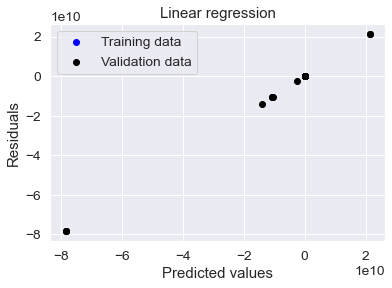

In [530]:
#plot between predicted values and residuals
plt.scatter(y_trpred, y_trpred - y_train, c = "blue",  label = "Training data")
plt.scatter(y_pred, y_pred - y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

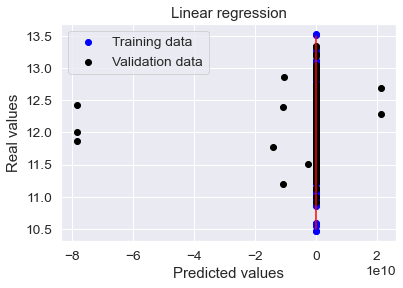

In [532]:
# Plot predictions - Real values
plt.scatter(y_trpred, y_train, c = "blue",  label = "Training data")
plt.scatter(y_pred, y_test, c = "black",  label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# 4.2.1 Five fold cross validation
Cross-validation is a vital step in evaluating a model.

In [533]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lr=LinearRegression()
# compute 5-fold cross-val scores
cv_scores=cross_val_score(lr, X, y, cv=5)

print("5-fold cross val scores (i.e R^2 values):{}". format(cv_scores))
print('Mean cross val score or mean R^2 value: {}'.format(np.mean(cv_scores)))

5-fold cross val scores (i.e R^2 values):[-3.83142267e+20 -3.64839315e+20 -1.31595961e+20 -3.90634116e+17
 -4.67232248e+18]
Mean cross val score or mean R^2 value: -1.7692810010567397e+20


### Large coefficients can lead to overfitting of Linear Regression; So, Regularization can penalize overfitting by handling colinearity.

# 4.3. Ridge Regression
Parameter is alpha like k in KNN (alpha=0 leads to overfitting, very high alpha leads to underfitting)

In [534]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print('Best alpha',alpha)

# predict on training data
y_trpred=ridge.predict(X_train)
# predict on test data
y_pred=ridge.predict(X_test)
print('R^2 value:{}'.format(ridge.score(X_test, y_test)))
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Square Error: {}".format(rmse))

Best alpha 1.0
R^2 value:0.9272926116657952
Root Mean Square Error: 0.10614642398215864


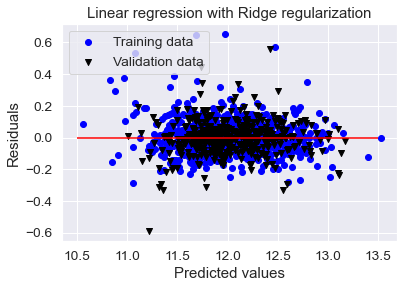

In [535]:
# Plot residuals
plt.scatter(y_trpred, y_trpred - y_train, c = "blue",  label = "Training data")
plt.scatter(y_pred, y_pred - y_test, c = "black", marker = "v", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

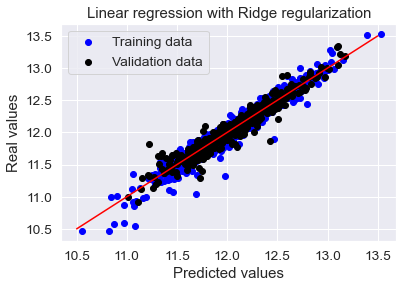

In [536]:
# Plot predictions - Real values
plt.scatter(y_trpred, y_train, c = "blue",  label = "Training data")
plt.scatter(y_pred, y_test, c = "black",  label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# 4.4. Lasso Regression

In [537]:
from sklearn.linear_model import Lasso
lasso=Lasso(alpha=0.1, normalize=True)
lasso.fit(X_train, y_train)
y_pred=lasso.predict(X_test)
print('R^2 value:{}'.format(lasso.score(X_test, y_test)))

R^2 value:-0.00011015472492204026


# Predictions

In [539]:
test_data_ML.head()

,Id,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,11622,5,6,1961,1961,468.0,144.0,270.0,0.649352,...,0,0,0,1,0,0,0,0,1,0
1,1462,14267,6,6,1958,1958,923.0,0.0,406.0,0.679552,...,0,0,0,1,0,0,0,0,1,0
2,1463,13830,5,5,1997,1998,791.0,0.0,137.0,0.653246,...,0,0,0,1,0,0,0,0,1,0
3,1464,9978,6,6,1998,1998,602.0,0.0,324.0,0.653081,...,0,0,0,1,0,0,0,0,1,0
4,1465,5005,8,5,1992,1992,263.0,0.0,1017.0,0.676895,...,0,0,0,1,0,0,0,0,1,0


In [540]:
test_array[:10]

array([[0.00000000e+00, 2.01013781e-01, 3.75000000e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [6.85871056e-04, 2.53385870e-01, 5.00000000e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [1.37174211e-03, 2.44733090e-01, 3.75000000e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [4.80109739e-03, 1.37256455e-01, 5.00000000e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [5.48696845e-03, 1.72382386e-01, 6.25000000e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [6.17283951e-03, 1.37216854e-01, 2.50000000e-01, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [541]:
#predictied values
new_pred=ridge.predict(test_array)
new_pred

array([11.52696038, 11.7607743 , 11.92131655, ..., 11.79409432,
       11.50738846, 12.12274768])

In [548]:
# predicted values dataframe
predicted_data=pd.DataFrame({'Id':test_data_ML['Id'],
                            'SalePrice_Predicted':new_pred})
predicted_data

,Id,SalePrice_Predicted
0,1461,11.526960
1,1462,11.760774
2,1463,11.921317
3,1464,12.017241
4,1465,12.038866
...,...,...
1454,2915,11.171953
1455,2916,11.117621
1456,2917,11.794094
1457,2918,11.507388


In [550]:
# predicted to exponential
# predicted values dataframe
predicted_data=pd.DataFrame({'Id':test_data_ML['Id'],
                            'SalePrice_Predicted':np.exp(new_pred)})
predicted_data


,Id,SalePrice_Predicted
0,1461,101413.386208
1,1462,128126.624007
2,1463,150439.539550
3,1464,165585.128639
4,1465,169204.913921
...,...,...
1454,2915,71107.837521
1455,2916,67347.506156
1456,2917,132467.726911
1457,2918,99447.829328


<AxesSubplot:xlabel='SalePrice_Predicted', ylabel='Count'>

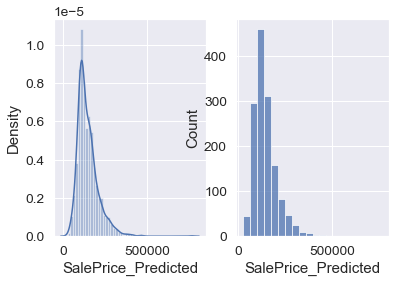

In [551]:
fig, ax =plt.subplots(1,2)
sns.distplot(predicted_data.SalePrice_Predicted, kde=True, ax=ax[0])
sns.histplot(predicted_data.SalePrice_Predicted, bins=20, ax=ax[1])

In [552]:
predicted_data.to_csv('Test_data_predicted_saleprice.csv')